In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import string
import tqdm

import sys
sys.path.append("/Users/benpeloquin/Code/")
from usefulities import *

from models import *

Settings

In [2]:
N_UTTERANCES = 4
N_MEANINGS = 4

In [3]:
utterances = list(string.letters)[:N_UTTERANCES]  # letters
meanings = list(range(N_MEANINGS))  # ints

In [4]:
n_true = len(meanings)
matrices = generate_all_boolean_matrices(len(utterances),
                                         len(meanings),
                                         n_true)
matrices = [(idxs, m) for idxs, m in matrices if
            all_meanings_available_filter(m)]

### Populate language

No context

In [143]:
def run_sim(i=0, num_contexts=1):
    p_utterances = np.random.dirichlet([2**v for v in range(len(utterances))])
    
    # Meanings can change by context
    contexts = [np.random.dirichlet([2**v for v in range(len(meanings))]) ]
    if num_contexts > 1:
        new_m = list(np.roll(contexts[0], i+1))
        contexts.append(new_m)
#     contexts = [np.random.dirichlet([2**v for v in range(len(meanings))]) for _ in range(num_contexts)]
#     contexts = [np.random.dirichlet([1. for v in range(len(meanings))]) for _ in range(num_contexts)]
        
    # Languages objects
    all_languages = []
    for idxs, m in matrices:
        d = matrix2dict(m, utterances, meanings)
        sems = Semantics(d)
        for p_m in contexts:
            language = Language(utterances, meanings, p_utterances, p_m, sems)
            all_languages.append((idxs, language))
      
    d_results = defaultdict(dict)
    for idxs, language in all_languages:
        agent = Agent(language)
        # Get efficiency
        ce, speaker_effort, listener_effort = \
            system_efficiency(agent, agent, language)
        if idxs in d_results:
            d_results[idxs]["CE"] += ce
            d_results[idxs]["speaker_effort"] += speaker_effort
            d_results[idxs]["listener_effort"] += listener_effort
        else:
            d_results[idxs]["CE"] = ce
            d_results[idxs]["speaker_effort"] = speaker_effort
            d_results[idxs]["listener_effort"] = listener_effort
            d_results[idxs]["sim_id"] = i

    # Average over contexts (p(c) is uniform over c)
    for idxs in d_results.keys():
        d_results[idxs]["CE"] /= len(contexts)
        d_results[idxs]["speaker_effort"] /= len(contexts)
        d_results[idxs]["listener_effort"] /= len(contexts)

    # Min assignments
    min_ce = np.inf
    min_idxs = None
    for idxs in d_results.keys():
        if d_results[idxs]["CE"] < min_ce:
            min_ce = d_results[idxs]["CE"]
            min_idxs = d_results[idxs]["CE"]
    
    # Set min data
    for idxs in d_results.keys():
        if d_results[idxs]["CE"] == min_ce:
            d_results[idxs]["is_min"] = True
        else:
            d_results[idxs]["is_min"] = False
        
    return d_results, p_utterances, contexts


def run_k_sims(k=10, num_contexts=3):
    datas = []
    for i in tqdm.tqdm(range(k)):
        res = run_sim(i, num_contexts)
        datas.append(res)
    return datas

def contains_ambiguities(lang_tuple, n_utterances=N_UTTERANCES, n_meanings=N_MEANINGS):
    """Functionality is custom to 4X4 matrices..."""
    first_row = set(range(4))
    second_row = set(range(4, 9))
    third_row = set(range(9, 13))
    fourth_row = set(range(13, 17))
    rows = []
    for x in lang_tuple:
        if x in first_row:
            rows.append(0)
        elif x in second_row:
            rows.append(1)
        elif x in third_row:
            rows.append(2)
        else:
            rows.append(3)
    return 4 - len(set(rows))

2 context

In [144]:
def run_full_sim(n_sims, num_context):
    d = run_k_sims(n_sims, num_context)
    results = []
    for i, (sim, utterances, contexts) in enumerate(d):
        for idx, sim_data in sim.items():
            d_curr = {'lang': idx,
                      'CE': sim_data['CE'],
                      'speaker_effort': sim_data['speaker_effort'],
                      'listener_effort': sim_data['listener_effort'],
                      'p_uterances': utterances,
                      'contexts': contexts,
                      'sim_id': i,
                      'is_min': sim_data['is_min'],
                      'n_sims': n_sims,
                      'num_context': num_context}
            results.append(d_curr)
    df_results = pd.DataFrame(results)
    df_results['contains_ambiguity'] = df_results['lang'].apply(lambda x: contains_ambiguities(x))
    return df_results

In [145]:
n = 50
all_data = []
for i in [1, 2, 3, 4]:
    all_data.append(run_full_sim(n, i))




  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:00<00:38,  1.27it/s]

  4%|▍         | 2/50 [00:01<00:38,  1.25it/s]

  6%|▌         | 3/50 [00:02<00:44,  1.05it/s]

  8%|▊         | 4/50 [00:03<00:45,  1.00it/s]

 10%|█         | 5/50 [00:04<00:44,  1.00it/s]

 12%|█▏        | 6/50 [00:06<00:45,  1.04s/it]

 14%|█▍        | 7/50 [00:07<00:44,  1.04s/it]

 16%|█▌        | 8/50 [00:08<00:43,  1.04s/it]

 18%|█▊        | 9/50 [00:09<00:43,  1.06s/it]

 20%|██        | 10/50 [00:10<00:42,  1.05s/it]

 22%|██▏       | 11/50 [00:11<00:40,  1.05s/it]

 24%|██▍       | 12/50 [00:12<00:40,  1.05s/it]

 26%|██▌       | 13/50 [00:13<00:38,  1.05s/it]

 28%|██▊       | 14/50 [00:14<00:37,  1.06s/it]

 30%|███       | 15/50 [00:15<00:36,  1.06s/it]

 32%|███▏      | 16/50 [00:16<00:35,  1.06s/it]

 34%|███▍      | 17/50 [00:17<00:34,  1.06s/it]

 36%|███▌      | 18/50 [00:19<00:33,  1.06s/it]

 38%|███▊      | 19/50 [00:20<00:32,  1.06s/it]

 40%|████      | 20/50 [00:21<00:31,

 94%|█████████▍| 47/50 [01:13<00:04,  1.55s/it]

 96%|█████████▌| 48/50 [01:14<00:03,  1.55s/it]

 98%|█████████▊| 49/50 [01:16<00:01,  1.55s/it]

100%|██████████| 50/50 [01:17<00:00,  1.55s/it]



  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:01<01:16,  1.57s/it]

  4%|▍         | 2/50 [00:03<01:13,  1.52s/it]

  6%|▌         | 3/50 [00:04<01:11,  1.52s/it]

  8%|▊         | 4/50 [00:06<01:09,  1.51s/it]

 10%|█         | 5/50 [00:07<01:10,  1.57s/it]

 12%|█▏        | 6/50 [00:09<01:10,  1.59s/it]

 14%|█▍        | 7/50 [00:11<01:08,  1.60s/it]

 16%|█▌        | 8/50 [00:12<01:06,  1.58s/it]

 18%|█▊        | 9/50 [00:14<01:04,  1.57s/it]

 20%|██        | 10/50 [00:15<01:02,  1.56s/it]

 22%|██▏       | 11/50 [00:17<01:00,  1.55s/it]

 24%|██▍       | 12/50 [00:18<00:58,  1.55s/it]

 26%|██▌       | 13/50 [00:20<00:57,  1.55s/it]

 28%|██▊       | 14/50 [00:21<00:55,  1.54s/it]

 30%|███       | 15/50 [00:23<00:53,  1.54s/it]

 32%|███▏      | 16/50 [00:24<00:52,

In [146]:
df_all = pd.concat(all_data)
df_mins = df_all[df_all['is_min']]

In [147]:
def scatter1(df, c=None, title=None):
    colors = ['red' if x else 'white' for x in df['is_min']]
    sizes = [60 if x else 20 for x in df['is_min']]
    jittered_scatter(x=df['speaker_effort'], y=df['listener_effort'], 
                     c=colors, alpha=0.4, edgecolor='b', s=sizes)
    axes = plt.axes()
    plt.xlabel("speaker effort")
    plt.ylabel("listener effort")
    axes.set_xlim((-0.2, 7))
    axes.set_ylim((-0.2, 2))
    if title is not None:
        plt.title(title)

/Users/benpeloquin/anaconda/envs/rsa-uid/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


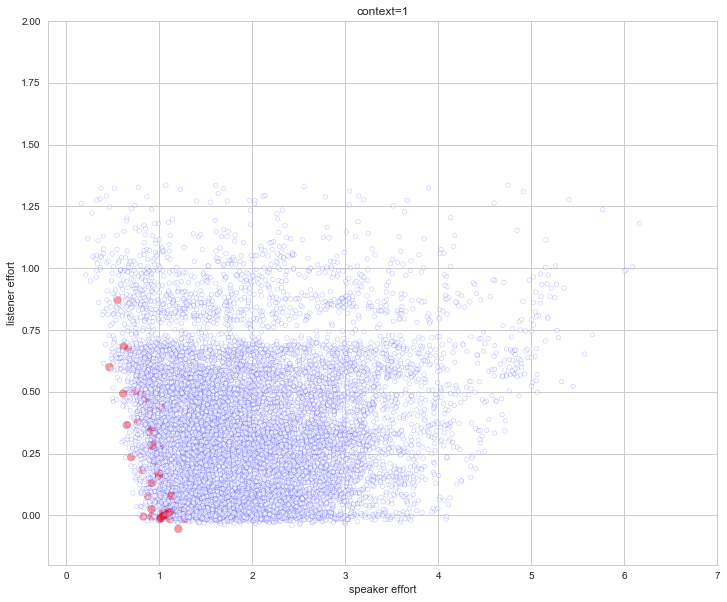

In [148]:
plt.figure(figsize=(12, 10))
colors = ['red' if x else 'white' for x in df_all['is_min']]
scatter1(df_all[(df_all['num_context'] == 1)], colors, "context={}".format(1))

/Users/benpeloquin/anaconda/envs/rsa-uid/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


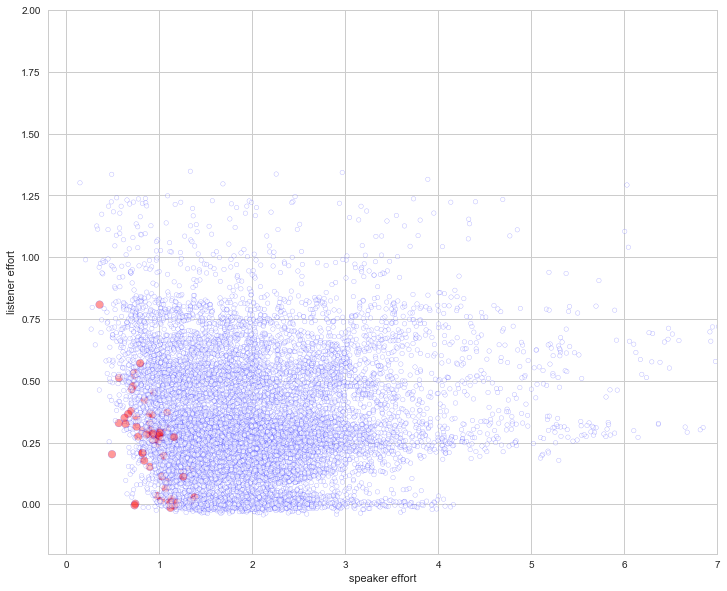

In [159]:
plt.figure(figsize=(12, 10))
scatter1(df_all[(df_all['num_context'] == 4)], "context={}".format(4))

In [150]:
print(df_mins.groupby(['num_context']).agg({'listener_effort': np.mean}))
print(df_mins.groupby(['num_context']).agg({'speaker_effort': np.mean}))

             listener_effort
num_context                 
1                   0.185164
2                   0.215675
3                   0.222273
4                   0.248791
             speaker_effort
num_context                
1                  0.970509
2                  0.949554
3                  0.952080
4                  0.927761


In [151]:
 df_mins  \
    .groupby(['num_context', 'contains_ambiguity']) \
    .count()

CE  contexts  is_min  lang  listener_effort  \
num_context contains_ambiguity                                                
1           0                   21        21      21    21               21   
            1                   24        24      24    24               24   
            2                    5         5       5     5                5   
2           0                   14        14      14    14               14   
            1                   36        36      36    36               36   
            2                   13        13      13    13               13   
3           0                   16        16      16    16               16   
            1                   33        33      33    33               33   
            2                   13        13      13    13               13   
4           0                    7         7       7     7                7   
            1                   44        44      44    44               44   
            2                   10        10      10    10               10   

                                n_sims  p_uterances  sim_id  speaker_effort  
num_context contains_ambiguity                                               
1           0                       21           21      21              21  
            1                       24           24      24              24  
            2                        5            5       5               5  
2           0                       14           14      14              14  
            1                       36           36      36              36  
            2                       13           13      13              13  
3           0                       16           16      16              16  
            1                       33           33      33              33  
            2                       13           13      13              13  
4           0                        7            7       7               7  
            1                       44           44      44              44  
            2                       10           10      10              10

/Users/benpeloquin/anaconda/envs/rsa-uid/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'listener effort')

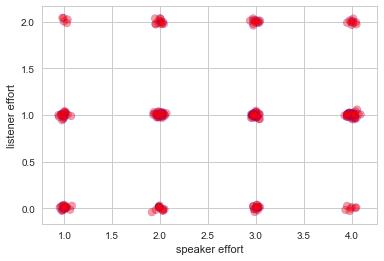

In [152]:
colors = ['red' if x else 'white' for x in df_mins['is_min']]
sizes = [60 if x else 20 for x in df_mins['is_min']]
jittered_scatter(x=df_mins['num_context'], y=df_mins['contains_ambiguity'],
                 c=colors, alpha=0.4, edgecolor='b', s=sizes)
axes = plt.axes()
plt.xlabel("speaker effort")
plt.ylabel("listener effort")

Text(0,0.5,'Cross Entropy')

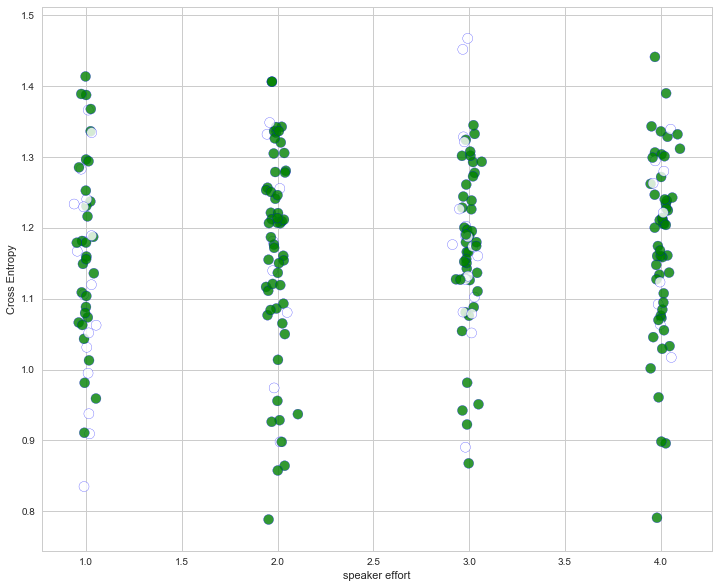

In [153]:
plt.figure(figsize=(12, 10))
colors = ['green' if x>0 else 'white' for x in plot_df['contains_ambiguity']]
sizes = [100 if x else 40 for x in plot_df['is_min']]
plot_df = df_all[df_all['is_min']]
jittered_scatter(x=plot_df['num_context'], y=plot_df['CE'], 
                 c=colors, alpha=0.8, edgecolor='b', s=sizes)
plt.xlabel("speaker effort")
plt.ylabel("Cross Entropy")

In [111]:
df_all.head()

,CE,contexts,is_min,lang,listener_effort,n_sims,num_context,p_uterances,sim_id,speaker_effort,contains_ambiguity
0,2.440192,"[[0.030806596530117566, 0.18610290734967408, 0...",False,"(6, 7, 8, 13)",0.540459,30,1,"[0.06083099373796479, 0.10455095898750855, 0.0...",0,1.899733,2
1,1.961403,"[[0.030806596530117566, 0.18610290734967408, 0...",False,"(5, 7, 12, 14)",0.482378,30,1,"[0.06083099373796479, 0.10455095898750855, 0.0...",0,1.479024,1
2,1.423325,"[[0.030806596530117566, 0.18610290734967408, 0...",False,"(12, 13, 14, 15)",1.152062,30,1,"[0.06083099373796479, 0.10455095898750855, 0.0...",0,0.271263,2
3,3.198577,"[[0.030806596530117566, 0.18610290734967408, 0...",False,"(0, 1, 2, 11)",0.471200,30,1,"[0.06083099373796479, 0.10455095898750855, 0.0...",0,2.727377,2
4,2.453811,"[[0.030806596530117566, 0.18610290734967408, 0...",False,"(1, 6, 11, 12)",0.000000,30,1,"[0.06083099373796479, 0.10455095898750855, 0.0...",0,2.453811,1


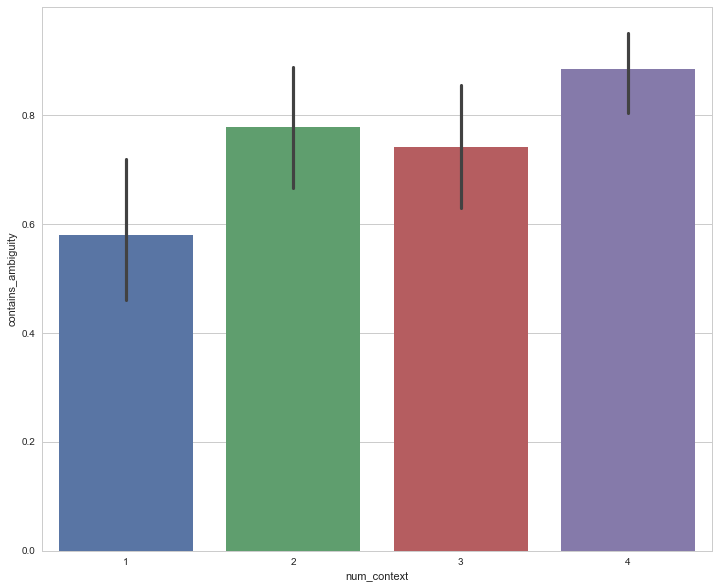

In [157]:
plt.figure(figsize=(12, 10))

df_mins = df_all[(df_all['is_min'])]
sns.barplot(x=df_mins['num_context'], y=df_mins['contains_ambiguity']!=0., ci=95)

In [113]:
df_mins.groupby(['num_context']).agg({'contains_ambiguity': np.mean})

,contains_ambiguity
num_context,
1,0.666667
2,1.085714
3,1.031250
4,1.060606


/Users/benpeloquin/anaconda/envs/rsa-uid/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(0, 1.2)

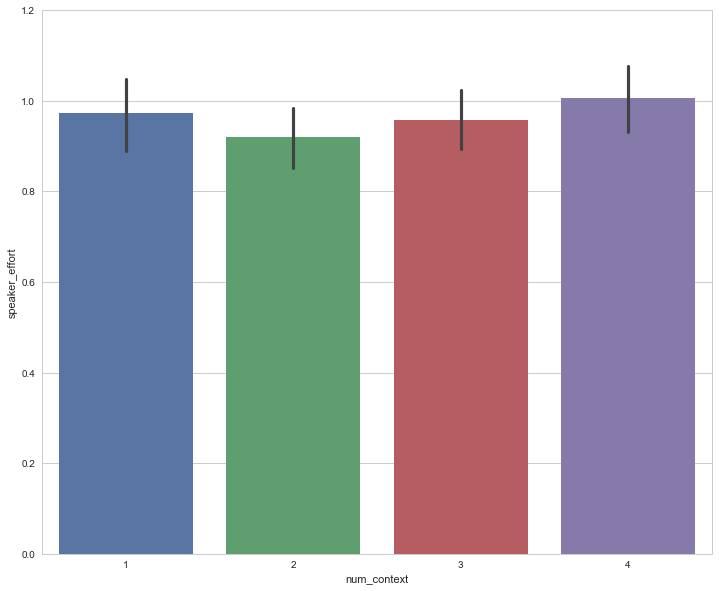

In [114]:
plt.figure(figsize=(12, 10))
sns.barplot(x=df_mins['num_context'], y=df_mins['speaker_effort'], ci=95)
axes = plt.axes()
axes.set_ylim(0, 1.2)

/Users/benpeloquin/anaconda/envs/rsa-uid/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(0, 1.2)

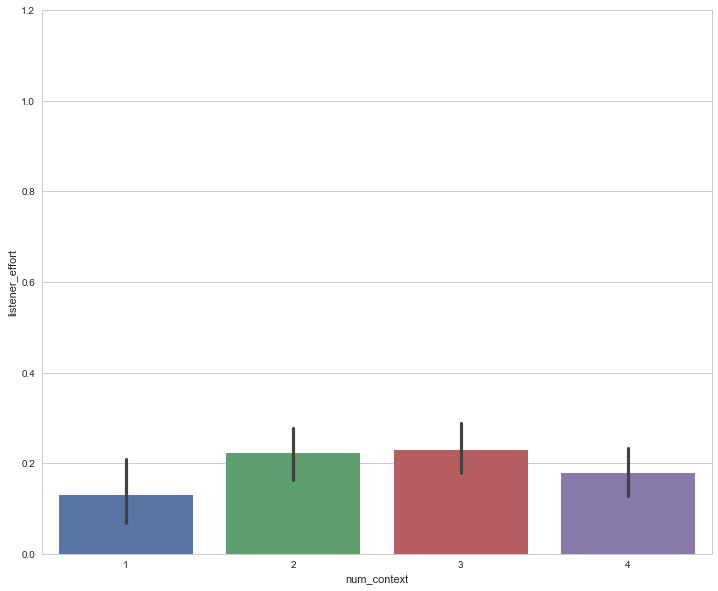

In [64]:
plt.figure(figsize=(12, 10))

df_mins = df_all[(df_all['is_min'])]
sns.barplot(x=df_mins['num_context'], y=df_mins['listener_effort'], ci=95)
axes = plt.axes()
axes.set_ylim(0, 1.2)